<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2025/blob/main/Homeworks/HW5_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейронные сети в биоинформатике

### Домашнее задание 6. Собираем свой GCN.

### О задании

Попробуйте улучшить метрику конволюциионной графовой сети с семинара. Для выполнения этого задания обязательно использование GPU.


In [1]:
import torch

# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!nvidia-smi

2.6.0+cu124
12.4
/bin/bash: line 1: nvidia-smi: command not found


In [2]:
%%bash
TORCH="2.5.1" # вставить версию torch, выданную в прошлом блоке
CUDA="cu124" # вставить ключ версии cuda из той же строчки
pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:00


In [3]:
!pip install decorator numpy matplotlib tqdm networkx ninja jinja2 rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 22.8 MB/s eta 0:00:00


# Задание 1. Закрепляем материал с семинара

Будем использовать датасет eSOL - данные о растворимости органических веществ. Наша графовая нейронная сеть (GNN) будет предсказывать растворимость этих веществ. Тип задачи - задача бинарной классификации

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [5]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
dataset = MoleculeNet(root=".", name="ESOL")
dataset

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing...
Done!


ESOL(1128)

In [6]:
print("Dataset type: ", type(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset targets: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print("Dataset sample: ", dataset[0])
print("Sample  nodes: ", dataset[0].num_nodes)
print("Sample  edges: ", dataset[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset targets:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


Как было сказано на семинаре, num_classes посчитано неверно. На самом деле у нас два класса:

0 - нерастворимое вещество

1 - растворимое вещество

Поэтому будем на аутпут архитектуры подавать 1 значение - 0 или 1

In [7]:
data = dataset[4] # Get the fifth graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[5, 9], edge_index=[2, 10], edge_attr=[10, 3], smiles='c1ccsc1', y=[1, 1])
Number of nodes: 5
Number of edges: 10
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [8]:
data.x

tensor([[ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [16,  0,  2,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1]])

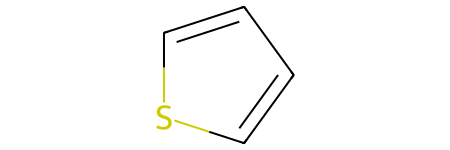

In [9]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(dataset[4]["smiles"])
molecule

Архитектура GNN

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size * 2, 1) # наше одно предсказанное число

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


Обучим нейросеть

In [11]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(dataset)
NUM_GRAPHS_PER_BATCH = 64
# train 80%, test 20%
loader = DataLoader(dataset[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(dataset[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y)) # RMSE
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

Следующий блок может выолняться вплоть до 20 минут. Это среднее время самого обычного приключения с возвращением в исходную точку. Если кажется, что это долго, вероятно стоит переключиться на GPU или выбрать поменбше эпох.

In [12]:
print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 2.600691080093384
Epoch 100 | Train Loss 0.8499088883399963
Epoch 200 | Train Loss 1.1651588678359985
Epoch 300 | Train Loss 0.4866017997264862
Epoch 400 | Train Loss 0.30471283197402954
Epoch 500 | Train Loss 0.6163718700408936
Epoch 600 | Train Loss 0.45041438937187195
Epoch 700 | Train Loss 0.6086057424545288
Epoch 800 | Train Loss 0.17959614098072052
Epoch 900 | Train Loss 0.4332345426082611
Epoch 1000 | Train Loss 0.29887133836746216
Epoch 1100 | Train Loss 0.4017169177532196
Epoch 1200 | Train Loss 0.30113887786865234
Epoch 1300 | Train Loss 0.2628348171710968
Epoch 1400 | Train Loss 0.30974820256233215
Epoch 1500 | Train Loss 0.2541029155254364
Epoch 1600 | Train Loss 0.3600638508796692
Epoch 1700 | Train Loss 0.32389920949935913
Epoch 1800 | Train Loss 0.33338403701782227
Epoch 1900 | Train Loss 0.5649053454399109


Визуализируем лосс

<Axes: >

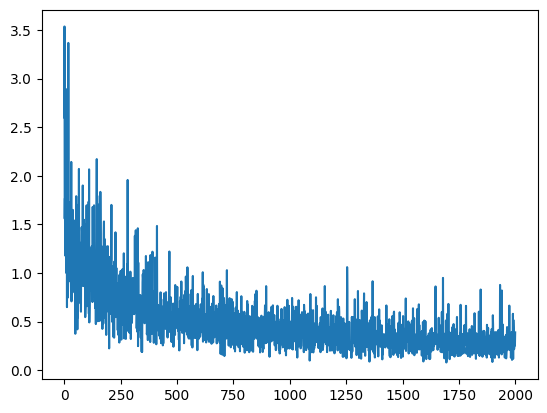

In [13]:
import seaborn as sns

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
# plt = sns.lineplot(loss_indices, losses_float)
plt = sns.lineplot(losses_float)
plt

Проанализируем результаты для одного батча

<Axes: xlabel='y_real', ylabel='y_pred'>

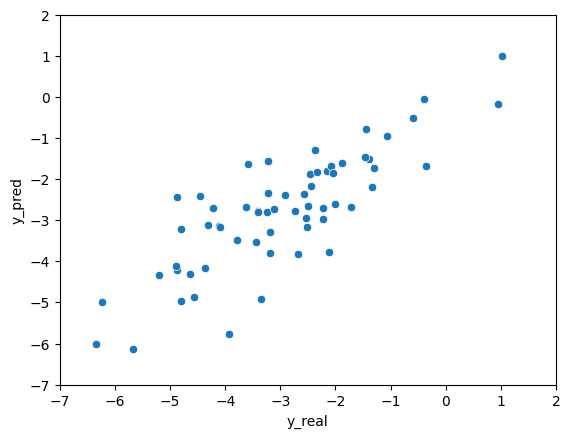

In [14]:
import pandas as pd

# прогоним один раз
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

In [15]:
import math

def test(model):
  model.eval()
  all_preds = []
  all_targets = []

  with torch.no_grad():
      for batch in test_loader:
          batch = batch.to(device)
          pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
          all_preds.append(pred.view(-1))
          all_targets.append(batch.y.view(-1))

  all_preds = torch.cat(all_preds, dim=0)
  all_targets = torch.cat(all_targets, dim=0)

  mse = torch.mean((all_preds - all_targets) ** 2)
  rmse = torch.sqrt(mse)

  mae = torch.mean(torch.abs(all_preds - all_targets))

  print("RMSE: {:.4f}".format(rmse.item()))
  print("MAE: {:.4f}".format(mae.item()))

In [16]:
test(model)

RMSE: 0.8627
MAE: 0.6459


По одной оси реальные y, по другой предсказания нейросети. Если предсказанные y идеально соответствуют реальным, то на графике должна быть одна диагональная линия без каких-либо выбросов в стороны

# Задание 2. Создаем свою графовую сеть
Как и в предыдущих дз, попробуйте создать свою архитектуру, которая побьет метрики с семинара. Можно измменять любые параметры (включая лосс функцию). Переверните там все вверх дном, но найдите, найдите эту архитектуру. Это метрики, которые не достойны падать!

In [18]:
import torch.nn as nn
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [47]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class TestMod(torch.nn.Module):  # Имя изменено на TestMod
    def __init__(self):
        # Init parent
        super(TestMod, self).__init__()
        torch.manual_seed(42)

        self.double_conv = double_conv(data.num_features, embedding_size)

        # GCN layers
        self.initial_conv = GCNConv(embedding_size, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size * 2, 1) # наше одно предсказанное число

    def forward(self, x, edge_index, batch_index):
        x = x.unsqueeze(1) #Добавляем размерность для channels, теперь [858, 1, 9]
        x = x.transpose(1, 2) #Меняем местами channels и features, теперь [858, 9, 1]
        x = x.unsqueeze(3) #Добавляем размерность для height, теперь [858, 9, 1, 1]

        x = self.double_conv(x)
        x = x.squeeze(3) #Убираем размерность height
        x = x.transpose(1, 2) #Возвращаем channels на место
        x = x.squeeze(1) #Убираем размерность канала

        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = TestMod()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

TestMod(
  (double_conv): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (initial_conv): GCNConv(64, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  59201


Обучение:

In [48]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(dataset)
NUM_GRAPHS_PER_BATCH = 64
# train 80%, test 20%
loader = DataLoader(dataset[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(dataset[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y)) # RMSE
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 3.0924789905548096
Epoch 100 | Train Loss 1.1502208709716797
Epoch 200 | Train Loss 0.37124043703079224
Epoch 300 | Train Loss 0.5492315888404846
Epoch 400 | Train Loss 2.2127256393432617
Epoch 500 | Train Loss 0.7083752751350403
Epoch 600 | Train Loss 0.4713161289691925
Epoch 700 | Train Loss 0.12289423495531082
Epoch 800 | Train Loss 0.8093472123146057
Epoch 900 | Train Loss 0.6850156188011169
Epoch 1000 | Train Loss 0.671407163143158
Epoch 1100 | Train Loss 0.08790295571088791


KeyboardInterrupt: 

<Axes: >

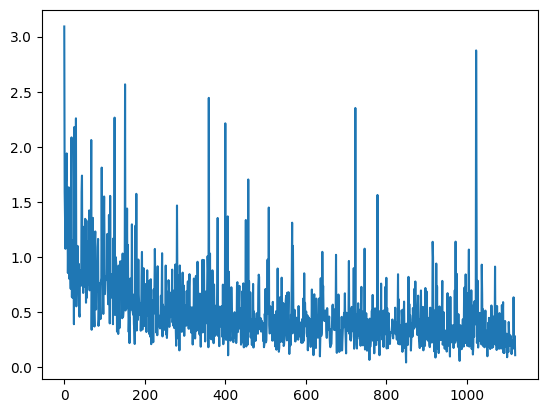

In [51]:
import seaborn as sns

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
# plt = sns.lineplot(loss_indices, losses_float)
plt = sns.lineplot(losses_float)
plt

Тестирование:

<Axes: xlabel='y_real', ylabel='y_pred'>

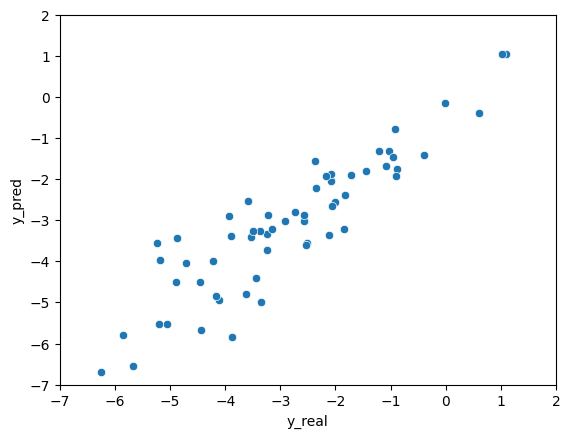

In [49]:
import pandas as pd

# прогоним один раз
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

In [50]:
test(model)

RMSE: 0.7616
MAE: 0.5720
